In [2]:
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cpu


Looking in indexes: https://download.pytorch.org/whl/cpu
  Using cached https://download.pytorch.org/whl/cpu/torch-2.9.0-cp313-none-macosx_11_0_arm64.whl.metadata (29 kB)
  Using cached https://download.pytorch.org/whl/cpu/torchvision-0.24.0-cp313-cp313-macosx_12_0_arm64.whl.metadata (5.9 kB)
  Using cached https://download.pytorch.org/whl/cpu/torchaudio-2.9.0-cp313-cp313-macosx_12_0_arm64.whl.metadata (6.9 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.4/74.4 MB 40.7 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 32.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 809.1/809.1 kB 25.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3/3 [torchaudio]3 [torchvision]


In [3]:
!pip install transformers folium matplotlib pandas scikit-learn scipy --quiet


In [4]:
import torch, transformers, folium, pandas, matplotlib, scipy
print("All libraries installed successfully!")
print("Torch:", torch.__version__)
print("Transformers:", transformers.__version__)


All libraries installed successfully!
Torch: 2.9.0
Transformers: 4.57.1


In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.ndimage import zoom
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from transformers import pipeline
import folium
import random
import warnings
warnings.filterwarnings("ignore")

print("Libraries imported successfully")

Libraries imported successfully


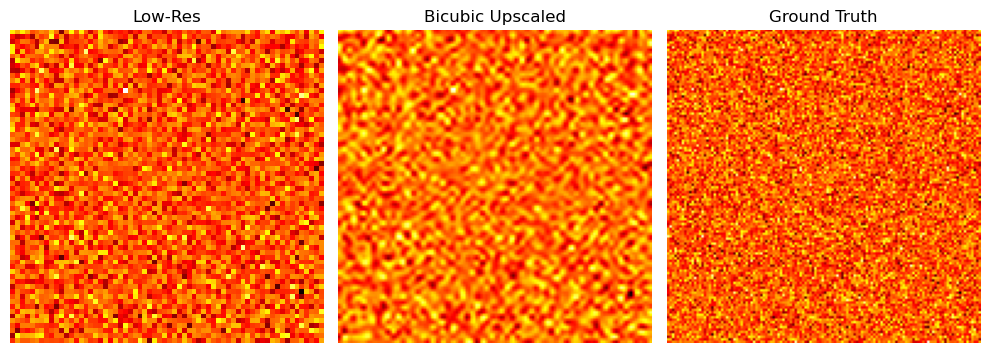

In [6]:
# ----------------------------
# STEP 2: Simulate Thermal Data
# ----------------------------
np.random.seed(0)
high_res = np.random.normal(loc=35, scale=2, size=(128,128))  # high-resolution temp grid
low_res = zoom(high_res, 0.5, order=3)                        # simulate low-res satellite
low_res_upscaled = zoom(low_res, 2, order=3)                  # bicubic interpolation

fig, ax = plt.subplots(1,3, figsize=(10,4))
ax[0].imshow(low_res, cmap="hot"); ax[0].set_title("Low-Res")
ax[1].imshow(low_res_upscaled, cmap="hot"); ax[1].set_title("Bicubic Upscaled")
ax[2].imshow(high_res, cmap="hot"); ax[2].set_title("Ground Truth")
for a in ax: a.axis("off")
plt.tight_layout(); plt.show()


In [7]:
# ----------------------------
# STEP 3: Prepare Training Tiles
# ----------------------------
def make_tiles(arr, size=32, stride=16):
    tiles = []
    for i in range(0, arr.shape[0]-size, stride):
        for j in range(0, arr.shape[1]-size, stride):
            tiles.append(arr[i:i+size, j:j+size])
    return np.stack(tiles)

X = make_tiles(low_res_upscaled)
y = make_tiles(high_res)
X = torch.tensor(X[:, None, :, :], dtype=torch.float32)
y = torch.tensor(y[:, None, :, :], dtype=torch.float32)

print("Training samples:", X.shape)

Training samples: torch.Size([36, 1, 32, 32])


In [8]:
# ----------------------------
# STEP 4: Define CNN model
# ----------------------------
class SmallSRCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 64, kernel_size=5, padding=2)
        self.conv2 = nn.Conv2d(64, 32, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(32, 1, kernel_size=3, padding=1)
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.conv3(x)
        return x

model = SmallSRCNN()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nn.MSELoss()

In [9]:
# ----------------------------
# STEP 5: Quick Training Loop
# ----------------------------
for epoch in range(3):
    model.train()
    optimizer.zero_grad()
    preds = model(X)
    loss = loss_fn(preds, y)
    loss.backward()
    optimizer.step()
    print(f"Epoch {epoch+1}/3  |  Loss: {loss.item():.4f}")

Epoch 1/3  |  Loss: 1053.3259
Epoch 2/3  |  Loss: 642.5889
Epoch 3/3  |  Loss: 303.2289


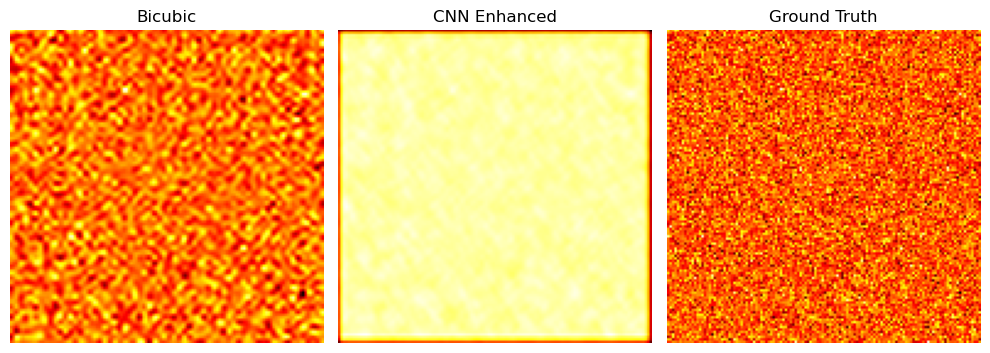

In [10]:
# ----------------------------
# STEP 6: Apply CNN
# ----------------------------
model.eval()
with torch.no_grad():
    input_tensor = torch.tensor(low_res_upscaled[None, None, :, :], dtype=torch.float32)
    output_tensor = model(input_tensor)
    cnn_enhanced = output_tensor.squeeze().numpy()

fig, ax = plt.subplots(1,3, figsize=(10,4))
ax[0].imshow(low_res_upscaled, cmap="hot"); ax[0].set_title("Bicubic")
ax[1].imshow(cnn_enhanced, cmap="hot"); ax[1].set_title("CNN Enhanced")
ax[2].imshow(high_res, cmap="hot"); ax[2].set_title("Ground Truth")
for a in ax: a.axis("off")
plt.tight_layout(); plt.show()

In [11]:
# ----------------------------
# STEP 7: Generate Synthetic Social Data
# ----------------------------
dates = pd.date_range("2024-07-01", periods=10)
data = []
for d in dates:
    for i in range(50):
        temp = np.random.normal(35, 3)
        text = random.choice([
            "It's so hot today!", "Too humid to walk!", "Heatwave warning!",
            "Perfect weather for ice cream", "Feeling exhausted", 
            "Walking to work in this heat is crazy", "Love sunny days!", "AC broke again"
        ])
        data.append([d, temp, text])
df_social = pd.DataFrame(data, columns=["date","lst_value","text"])

In [12]:
# ----------------------------
# STEP 8: Sentiment Analysis
# ----------------------------
sentiment_pipe = pipeline("sentiment-analysis", model="distilbert-base-uncased-finetuned-sst-2-english")
sample_df = df_social.sample(200, random_state=0).copy()
sample_df["sentiment"] = sample_df["text"].apply(lambda x: sentiment_pipe(x)[0]["label"])

config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

Device set to use mps:0


In [14]:
# ----------------------------
# STEP 9: Persona Tagging
# ----------------------------
def persona_tag(text):
    t = text.lower()
    if "work" in t: return "commuter"
    if "ac" in t: return "comfort seeker"
    if "home" in t: return "resident"
    return "other"
sample_df["persona"] = sample_df["text"].apply(persona_tag)

Correlation between heat & negative sentiment: -0.304


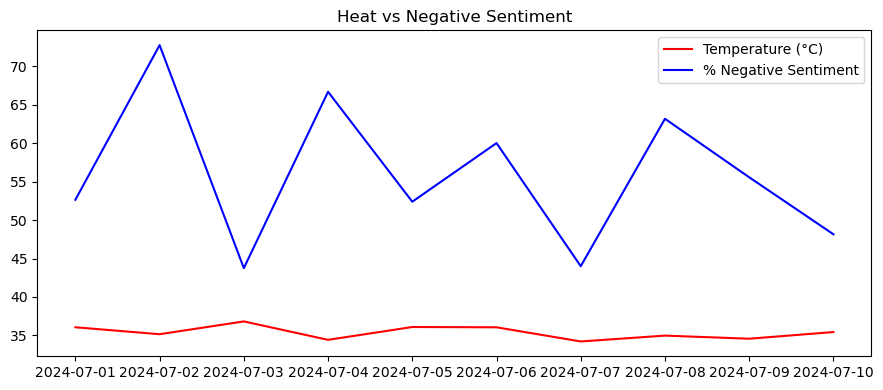

In [15]:
# ----------------------------
# STEP 10: Correlation Analysis
# ----------------------------
daily_temp = sample_df.groupby("date")["lst_value"].mean().reset_index()
daily_sent = sample_df.groupby(["date","sentiment"]).size().unstack(fill_value=0)
daily_sent["total"] = daily_sent.sum(axis=1)
daily_sent["negative_ratio"] = daily_sent.get("NEGATIVE",0)/daily_sent["total"]
daily = pd.merge(daily_temp, daily_sent, on="date", how="inner")
corr = daily["lst_value"].corr(daily["negative_ratio"])
print(f"Correlation between heat & negative sentiment: {corr:.3f}")

plt.figure(figsize=(9,4))
plt.plot(daily["date"], daily["lst_value"], "r-", label="Temperature (°C)")
plt.plot(daily["date"], daily["negative_ratio"]*100, "b-", label="% Negative Sentiment")
plt.legend(); plt.title("Heat vs Negative Sentiment"); plt.tight_layout(); plt.show()

In [17]:
# ----------------------------
# STEP 11: Quick Map Visualization
# ----------------------------
lat_min, lat_max = 40.6, 40.9
lon_min, lon_max = -74.05, -73.85
sample_df["lat"] = np.random.uniform(lat_min, lat_max, len(sample_df))
sample_df["lon"] = np.random.uniform(lon_min, lon_max, len(sample_df))

m = folium.Map(location=[40.73, -73.95], zoom_start=11)
for _, r in sample_df.iterrows():
    color = "red" if r["sentiment"]=="NEGATIVE" else "green"
    folium.CircleMarker([r["lat"], r["lon"]],
                        radius=3, color=color, fill=True, fill_opacity=0.6).add_to(m)
m.save("urban_heat_sentiment_map.html")
print(" Map saved as 'urban_heat_sentiment_map.html'")

 Map saved as 'urban_heat_sentiment_map.html'


In [18]:
# ----------------------------
# STEP 12: Summary
# ----------------------------
print("\n--- PROJECT SUMMARY ---")
print("CNN trained for heat image enhancement")
print("Sentiment + persona extraction complete")
print("Correlation and visualization done")
print("Interactive map generated successfully")


--- PROJECT SUMMARY ---
CNN trained for heat image enhancement
Sentiment + persona extraction complete
Correlation and visualization done
Interactive map generated successfully


In [19]:
from IPython.display import IFrame
IFrame("urban_heat_sentiment_map.html", width=800, height=500)
